In [2]:
import pathlib
import matplotlib.pyplot as plt
import utils
from torch import nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
import os

In [7]:
class Model(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:
                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """
        super().__init__()
        # TODO: Implement this function (Task  2a)
        num_filters = [32, 64, 128]  # Set number of filters in each conv layer
        self.num_classes = num_classes
        # Define the first convolutional layer
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels,
                out_channels=num_filters[0],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                num_filters[0],
                out_channels=num_filters[0],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = num_filters[0]),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p = 0.1)
        )
        # Define the rest of the convolutional layers
        for i in range(1, len(num_filters)):
            self.feature_extractor = nn.Sequential(
                self.feature_extractor,
                nn.Conv2d(
                    in_channels=num_filters[i-1],
                    out_channels=num_filters[i],
                    kernel_size=3,
                    stride=1,
                    padding=1
                ),
                nn.Conv2d(
                    in_channels=num_filters[i],
                    out_channels=num_filters[i],
                    kernel_size=3,
                    stride=1,
                    padding=1
                ),
                nn.ReLU(),
                nn.BatchNorm2d(num_features = num_filters[i]),
                nn.MaxPool2d(
                    kernel_size=2,
                    stride=2
                ),
                nn.Dropout(p = 0.1)
            )

        self.num_output_features = 4*4*128
        # Initialize the first fully connected layer
        # Inputs all extracted features from the convolutional layers
        num_nodes = 64
        # Outputs num_nodes features
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, num_nodes),
            nn.ReLU(),
            nn.BatchNorm1d(num_features = num_nodes)
        )
        # Initialize the final fully connected layer
        # Inputs num_nodes features
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
            self.classifier,
            nn.Linear(num_nodes, num_classes),
        )


    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)
        out = self.classifier(out)
        expected_shape = (batch_size, self.num_classes)
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out

In [8]:
epochs = 10
batch_size = 64
learning_rate = 1e-3
early_stop_count = 4
dataloaders = load_cifar10(batch_size)
model = Model(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
    optimizer = "Adam"
)
trainer.train()
print("Finished training")

Files already downloaded and verified
Files already downloaded and verified
Model(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Dropout(p=0.1, inplace=False)
      )
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Dropout(p=0.1, inplace=False)
    )
    (1): Conv

In [10]:
trainer.load_best_model()
model = trainer.model
dataloader_train, dataloader_val, dataloader_test = dataloaders
train_loss, train_acc = compute_loss_and_accuracy(
    dataloader_train, model, nn.CrossEntropyLoss()
)
validation_loss, validation_acc = compute_loss_and_accuracy(
    dataloader_val, model, nn.CrossEntropyLoss()
)
test_loss, test_acc = compute_loss_and_accuracy(
    dataloader_test, model, nn.CrossEntropyLoss()
)
print("Best model training loss:", train_loss)
print("Best model training accuracy:", train_acc)
print("Best model validation accuracy:", validation_acc)
print("Best model test accuracy:", test_acc)

Best model training loss: 0.345916174829091
Best model training accuracy: 0.8813566856330014
Best model validation accuracy: 0.8038
Best model test accuracy: 0.7942


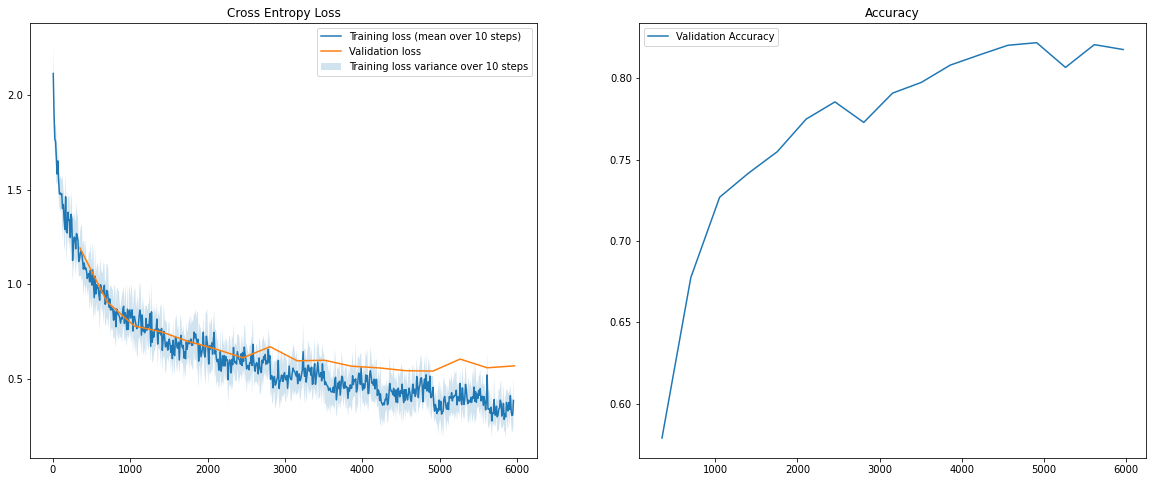

In [11]:
def create_plots(trainer: Trainer, name: str):
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    utils.plot_loss(trainer.train_history["loss"], label="Training loss", npoints_to_average=10)
    utils.plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    utils.plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()
    
create_plots(trainer, "task3.2")